In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import libraries

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
#Defines directory paths for train, test, and validation datasets.
image_dir = '/content/drive/MyDrive/datasets/archive (2)'

classes = os.listdir(image_dir)
print(classes)

['PNEUMONIA', 'NORMAL', 'COVID']


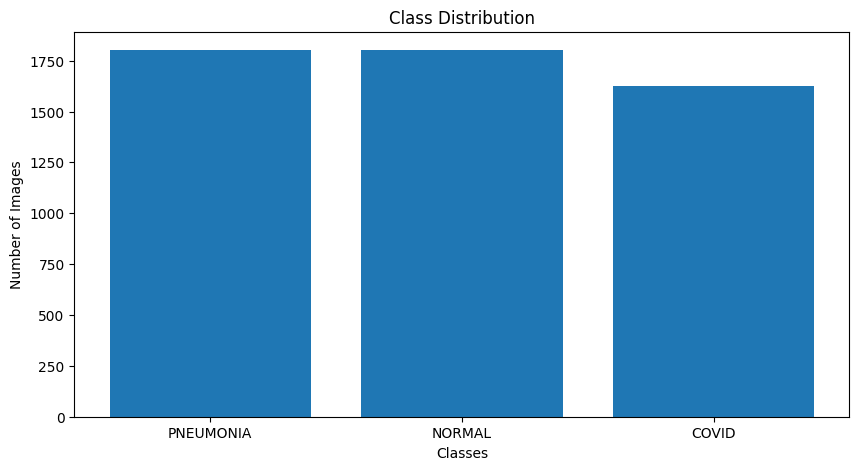

In [ ]:
from collections import Counter
class_counts=Counter()
for cls in  classes:
  class_dir=os.path.join(image_dir,cls)
  class_counts[cls]=len(os.listdir(class_dir))

#plot class distribution

plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(),class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title("Class Distribution")
plt.show()

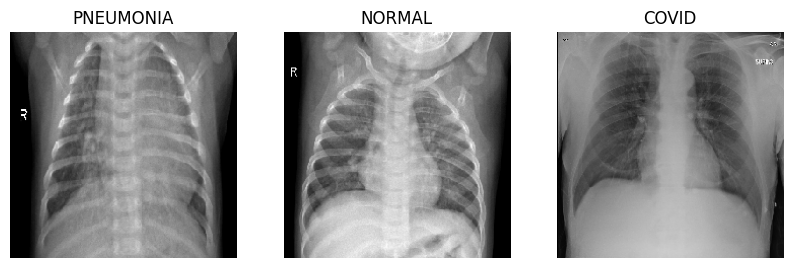

In [ ]:
class_dirs = os.listdir(image_dir)
plt.figure(figsize=(10, 10))
for i, cls in enumerate(class_dirs, start=1):
    img_path = os.path.join(image_dir, cls, os.listdir(os.path.join(image_dir, cls))[0])
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()

# creating a tensorflow dataset

In [ ]:
img_size=256
batch_size=32

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    shuffle=True,
    image_size=(img_size,img_size),
    batch_size=batch_size,
    labels='inferred',
    label_mode='int')

Found 5228 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
print(class_names)

['COVID', 'NORMAL', 'PNEUMONIA']


In [ ]:
len(dataset)

164

In [ ]:
#splitting tf dataset
def split_dataset(ds,train_ratio=0.8,val_ratio=0.1,test_ratio=0.1,shuffle=True):

  dataset_size=len(ds)

  train_size=int(train_ratio*dataset_size)
  val_size=int(val_ratio*dataset_size)
  test_size=dataset_size-train_size-val_size

  #shuffle dataset if required

  if shuffle:
    ds=ds.shuffle(dataset_size)

    #split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [ ]:
for i in [train_ds,val_ds,test_ds]:
  print(len(i))

131
16
17


# **Optimize the data pipeline for training machine learning models**

In [ ]:
# Shuffling dataset before caching
train_ds = train_ds.shuffle(buffer_size=1000).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.shuffle(buffer_size=1000).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.shuffle(buffer_size=1000).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# **Defining pipeline for resizing, rescaling/normalizing the data and for data augmentation**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_size, img_size),     # Though already resized, this works for other test data
    tf.keras.layers.Rescaling(1.0/255)     # Normalizing the pixels
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomContrast(0.1),
     keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Small shifts
    keras.layers.GaussianNoise(stddev=0.05),  # Simulate image noise
    keras.layers.RandomHeight(factor=(-0.1, 0.1)), #random height changes
    keras.layers.RandomWidth(factor=(-0.1, 0.1)), #random width changes

])


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

# Freeze base model layers
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=20, validation_data=val_ds, verbose=1)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1399s 348ms/step - accuracy: 0.8381 - loss: 2.2308 - val_accuracy: 0.9316 - val_loss: 0.9239
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9454 - loss: 0.8070 - val_accuracy: 0.9609 - val_loss: 0.5230
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.9580 - loss: 0.4993 - val_accuracy: 0.9648 - val_loss: 0.3629
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.9638 - loss: 0.3645 - val_accuracy: 0.9668 - val_loss: 0.2780
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.9586 - loss: 0.2983 - val_accuracy: 0.9727 - val_loss: 0.2262
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9549 - loss: 0.2755 - val_accuracy: 0.9688 - val_loss: 0.2038
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 0.9593 - loss: 0.2339 - val_accuracy: 0.9707 - val_loss: 0.1925
Epoch 8/20
131/131 ━━━━━━━━━━━

In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/model/xray.h5')

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,375,691 (92.99 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 525,320 (2.00 MB)

In [ ]:
model.evaluate(test_ds)

17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 93ms/step - accuracy: 0.9939 - loss: 0.0932


[0.1065351590514183, 0.9852941036224365]

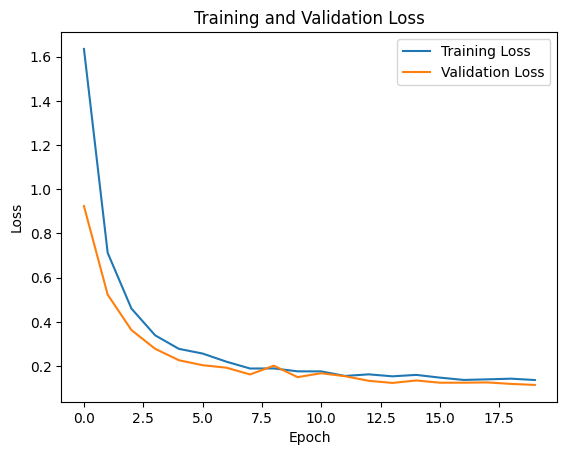

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

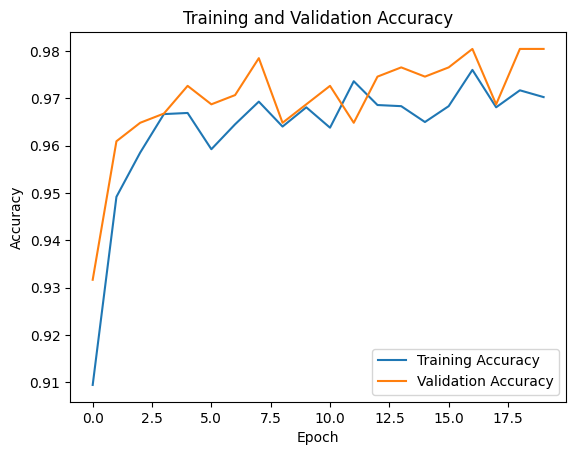

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred_probs = model.predict(test_ds)
print(y_pred_probs)

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step
[[8.0547361e-05 4.5947544e-03 9.9532473e-01]
 [8.2114469e-03 6.0227191e-01 3.8951665e-01]
 [9.9993992e-01 5.9434956e-07 5.9441925e-05]
 ...
 [5.0898269e-04 1.7656595e-02 9.8183447e-01]
 [1.1024539e-05 9.9911660e-01 8.7237626e-04]
 [1.3620497e-04 4.2605924e-04 9.9943775e-01]]


In [ ]:
y_pred = np.argmax(y_pred_probs, axis=1)  # This returns which column has the highest value
print(y_pred)

[2 1 0 1 0 1 0 2 0 0 1 2 0 2 1 2 0 0 0 0 1 2 0 1 0 1 1 0 2 1 0 1 1 2 1 2 0
 2 0 1 1 2 0 2 2 0 2 1 1 0 1 2 0 0 0 2 2 0 0 2 2 0 2 2 2 2 2 1 0 0 2 1 1 1
 2 0 0 0 2 0 1 2 2 2 0 0 2 0 1 0 2 0 2 2 0 1 0 0 2 1 1 0 0 0 0 0 1 2 1 2 2
 0 0 1 2 2 2 0 2 0 2 2 0 2 2 0 2 2 0 1 1 0 0 1 0 0 1 2 1 0 1 2 2 2 2 1 0 2
 2 2 2 2 1 0 1 2 1 0 0 0 1 1 0 1 0 2 2 1 1 0 2 1 2 1 2 1 2 2 1 0 0 1 2 1 2
 1 2 2 0 1 1 0 2 0 2 2 0 2 1 1 1 1 2 0 2 1 2 2 2 1 0 2 0 1 2 1 0 0 0 0 2 0
 0 1 1 2 0 2 2 1 2 1 0 2 2 0 0 1 1 1 1 0 1 0 2 1 1 1 1 2 0 0 0 0 2 2 2 2 2
 0 0 2 2 2 2 0 1 2 0 0 2 1 2 0 2 1 0 0 1 2 0 1 1 1 2 0 0 0 0 0 1 0 2 0 2 2
 0 1 0 1 0 0 0 0 0 1 0 2 1 0 1 0 0 1 2 0 2 0 1 0 1 2 1 1 2 1 2 0 1 1 0 2 1
 1 1 2 0 1 2 0 1 2 0 2 1 1 2 2 0 1 0 2 0 2 1 0 1 0 2 0 2 0 2 1 2 1 1 0 1 0
 2 1 2 2 2 1 1 2 1 0 2 1 2 1 1 1 0 2 2 2 0 1 1 1 1 0 0 2 0 2 0 2 1 0 2 0 0
 1 2 2 1 1 2 0 2 1 0 2 1 1 0 2 1 0 1 2 1 1 1 1 1 1 1 0 2 2 2 1 0 0 1 0 0 1
 1 1 1 0 2 2 0 0 2 0 2 0 1 2 1 0 1 0 1 1 1 1 1 0 0 1 0 1 2 0 2 2 1 2 2 1 2
 2 2 1 2 0 1 0 1 2 1 0 0 

# **Let's make predictions on some sample images**

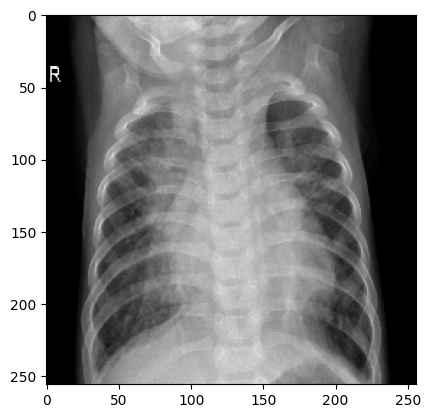

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    plt.imshow((images_batch[0].numpy().astype('uint8')))
# for print(images_batch[0]) , we can see this is a tensor, we convert this to numpy array before plotting image
# Instead of plt.imshow, if we print this, we will see it as a 3 dimesional array RGB

First image to predict
First images actual label: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted label: PNEUMONIA


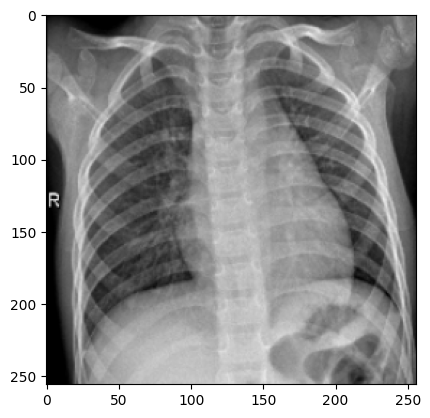

In [ ]:
for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[1].numpy().astype('uint8')# [0] gives the first image of the batch 1, 2, 3,
                                                      #for 2nd, 3rd ....
  first_label=labels_batch[0].numpy()
  print("First image to predict")
  plt.imshow(first_image)
  print("First images actual label:",class_names[first_label])#class_names gives the names instead of 0,1
                                                                  #or 2
  batch_prediction=model.predict(images_batch) # This is the prediction of all 32 images of the
                                                #first batch

  print("Predicted label:",class_names[np.argmax(batch_prediction[0])]) # this is the prediction of the first image

   # Each time we run this, we'll get a new image due to shuffle in ds.take()

In [ ]:
# We do this to predict the model on a random image(beyond the dataset, now we're defining a function
def predict(model, img): # A function which takes model and image as input
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())   # convert image into image array
    img_array = tf.expand_dims(img_array, 0)    # create a batch out of it
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


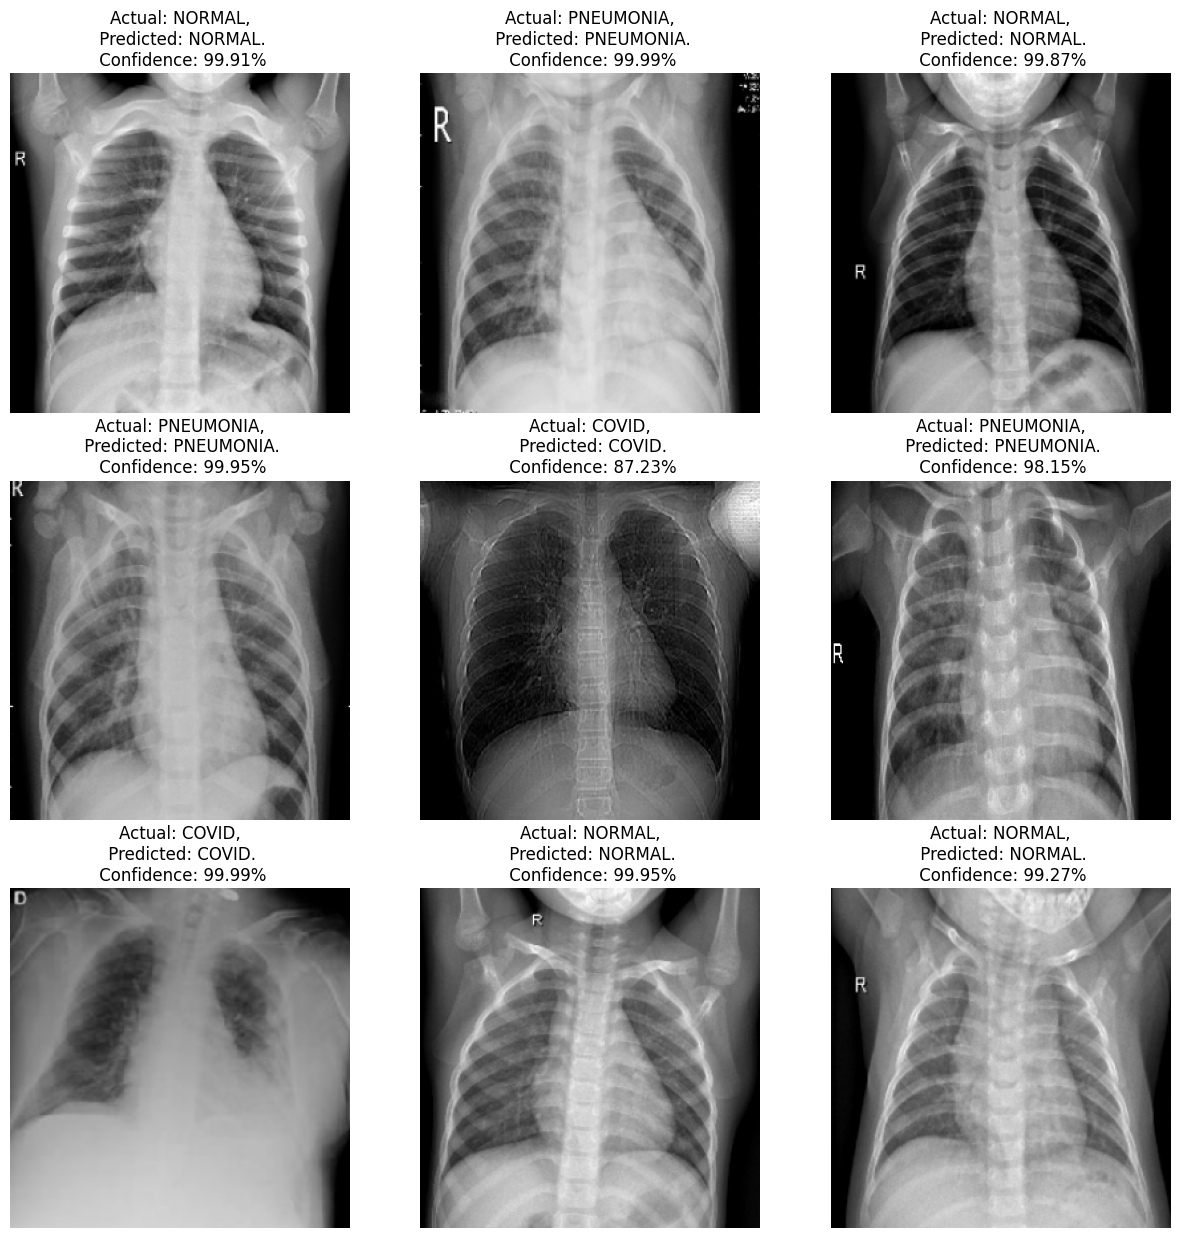

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(9):     # picking first 9 images from the batch
        ax = plt.subplot(3, 3, i + 1)  # subplot to show all the images
        plt.imshow(images[i].numpy().astype("uint8"))   # Show the image

        predicted_class, confidence = predict(model, images[i].numpy())  # Using above defined function
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")  # Turn off the grid